<a href="https://colab.research.google.com/github/jamesakibble/MSc_thesis/blob/main/XGBoost_gridsearchcv_escobal417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBoost harnessing gridsearch cv to determine the best yield prediction parameters. Actual Vs. Predicted yield and feature importance bar plot generated for further analysis of results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
dataset = pd.read_csv('escobal_417_use.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
X=dataset.drop(["yield", "seed_stage", "SAVI_ripe", "EVI_ripe", "NDVI_ripe", "EVI_repro", "NDVI_repro", "SAVI_veg", "SAVI_repro", "EVI_veg", "precip_airport", "temp_range", "avg_temp", "emer_har", "total_precip", "wet_day_freq", "precip_airport_meteo", "total_length", "max_temp", "hum", "min_temp", "sunlight"], axis=1)
print(X)

   emer_season  drought_days  NDVI_veg
0          SON             7  0.848325
1          JJA             7  0.634768
2          DJF             5  0.346871
3          JJA             6  0.662926
4          JJA             7  0.765100
5          JJA             7  0.684492
6          MAM             9  0.544593
7          DJF             7  0.535999
8          MAM             7  0.661131
9          SON             7  0.658494
10         JJA             9  0.497482
11         JJA            15  0.684212
12         DJF             6  0.362064
13         SON             7  0.563282
14         DJF             6  0.516336
15         JJA             6  0.489542
16         MAM             9  0.396192
17         MAM             6  0.513335
18         JJA             8  0.453235
19         JJA            13  0.480822
20         JJA            15  0.549389
21         MAM             8  0.539555
22         JJA             7  0.494455
23         MAM            14  0.751582
24         JJA           

In [ ]:
y = y.reshape(len(y),1)

In [ ]:
#Encoding categorical
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
pd.get_dummies(dataset, drop_first=True)
X = np.array(ct.fit_transform(X))

In [ ]:
print(X)

[[ 0.    0.    0.    1.    7.    0.85]
 [ 0.    1.    0.    0.    7.    0.63]
 [ 1.    0.    0.    0.    5.    0.35]
 [ 0.    1.    0.    0.    6.    0.66]
 [ 0.    1.    0.    0.    7.    0.77]
 [ 0.    1.    0.    0.    7.    0.68]
 [ 0.    0.    1.    0.    9.    0.54]
 [ 1.    0.    0.    0.    7.    0.54]
 [ 0.    0.    1.    0.    7.    0.66]
 [ 0.    0.    0.    1.    7.    0.66]
 [ 0.    1.    0.    0.    9.    0.5 ]
 [ 0.    1.    0.    0.   15.    0.68]
 [ 1.    0.    0.    0.    6.    0.36]
 [ 0.    0.    0.    1.    7.    0.56]
 [ 1.    0.    0.    0.    6.    0.52]
 [ 0.    1.    0.    0.    6.    0.49]
 [ 0.    0.    1.    0.    9.    0.4 ]
 [ 0.    0.    1.    0.    6.    0.51]
 [ 0.    1.    0.    0.    8.    0.45]
 [ 0.    1.    0.    0.   13.    0.48]
 [ 0.    1.    0.    0.   15.    0.55]
 [ 0.    0.    1.    0.    8.    0.54]
 [ 0.    1.    0.    0.    7.    0.49]
 [ 0.    0.    1.    0.   14.    0.75]
 [ 0.    1.    0.    0.    6.    0.52]
 [ 0.    1.    0.    0.  

In [ ]:
#Variance Inflation Factor (VIF) analysis to uncover non-linear collinearity - used for continuous data.
#X.drop(["emer_season", "yield", "SAVI_ripe", "EVI_ripe", "NDVI_ripe", "NDVI_repro", "SAVI_repro", "SAVI_veg", "NDVI_veg", "EVI_veg", "total_length", "temp_range", "max_temp", "hum", "emer_har", "min_temp", "wet_day_freq", "sunlight", "total_precip"], axis=1)
#vif = np.array(X, dtype=int)
#vif
#vif["features"] = X.columns
#vif["vif_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#print(vif)

ValueError: ignored

In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
# Split data 80% train, 20% test for model testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800, 1000],
    'colsample_bytree': [0.2, 0.5, 1, 2, 4],
    'max_depth': [1,2,5,10, 15],
    'reg_alpha': [1, 2, 5, 10, 15],
    'reg_lambda': [1, 5, 10, 15],
    'subsample': [0.1, 0.5, 1, 2]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 15948 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 23068 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 28802 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 36380 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 43304 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 58320 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 80000 out of 80000 | elapsed: 15.9min finished


[19:13:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_grid = model.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(r2_score(y_test, y_pred_grid))
print(mean_absolute_error(y_test, y_pred_grid))
mean_squared_error(y_test, y_pred_grid)
print(np.sqrt(mean_squared_error(y_test, y_pred_grid)))
model.best_estimator_

0.5376047857958611
693.7344960312503
913.6256253930815


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.1, verbosity=1)

In [ ]:
# Mode parameters from best results
model.best_params_

{'colsample_bytree': 1,
 'max_depth': 1,
 'n_estimators': 1000,
 'reg_alpha': 10,
 'reg_lambda': 1,
 'subsample': 0.1}

In [ ]:
# Comparing model predicted yield to actual yield values
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_grid.reshape(len(y_pred_grid), 1), y_test.reshape(len(y_test), 1)), 1))

[[9032.72 8966.23]
 [7001.43 8433.88]
 [7507.22 8937.64]
 [7215.33 5545.69]
 [6897.77 6359.57]
 [9480.29 9134.88]
 [8749.3  9118.18]
 [6705.21 6887.57]
 [9556.85 9347.08]]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


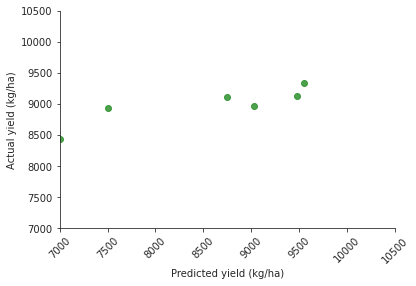

In [ ]:
#Predicted vs actual yield scatter graph
import seaborn as sns
sns.set_style('ticks')
sns.regplot(y_pred_grid, y_test, data=dataset, color="forestgreen", fit_reg=False)
#np.concatenate((y_pred_grid.reshape(len(y_pred_grid), 1), y_test.reshape(len(y_test), 1)), 1)
plt.xlim(7000,10500)
plt.ylim(7000,10500)
plt.xticks(rotation=45)
plt.xlabel("Predicted yield (kg/ha)")
plt.ylabel("Actual yield (kg/ha)")
sns.despine()
plt.savefig('fed67_scatter.png')

[0.07 0.16 0.21 0.17 0.18 0.21]


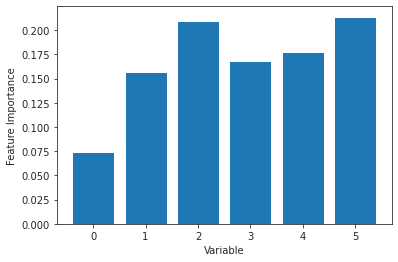

In [ ]:
# Feature importance bar plot of variables influence on yield prediction
print(model.best_estimator_.feature_importances_)
# Plotting
plt.bar(range(len(model.best_estimator_.feature_importances_)), model.best_estimator_.feature_importances_)
model.best_estimator_. get_booster().get_score(importance_type="gain")
plt.xlabel("Variable")
plt.ylabel("Feature Importance")
plt.show()